# Unsupervised Learning Project


## Introduction

In this project, I will be examining a dataset of breast cancer diagnosis from the UCI Machine Learning Repository. This data comes from a study from researchers at University of Wisconsin, and examines charachteristics of the nuclei of breast cancer tumor cells. We'll use several unsupervisesd approaches: heirarchical clustering, k-means clusting. These methods will be used to predict whether a tumor is benign or malignant, and be compared to the labeled output. We will also construct a supervised learning model (random forest classifier) and compare the performance of that model.

## Exploratoy Data Analysis

First, we'll import any necessary libraries, as well as the data for the report.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [ ]:
# Examine the first few rows of the data
print(X.head())
print('------------------------------------------------\n')
print(y.head())
print('======================================================================\n')

# Get basic statistics for numerical features (if any)
print(X.describe())
print('------------------------------------------------\n')
print(y.describe())
print('======================================================================\n')

# Check for missing values
print("Missing Values:")
print(X.isnull().sum())
print('\n')
print(y.isnull().sum())

   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

Diagnosis
B    357
M    212
Name: count, dtype: int64


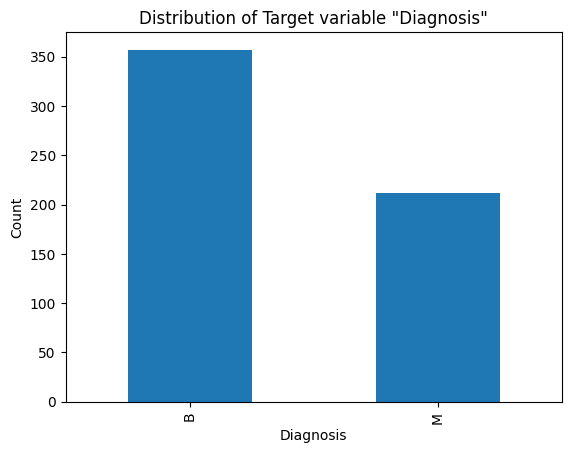

In [ ]:
# Explore the distribution of the target variable
print(y['Diagnosis'].value_counts())
y['Diagnosis'].value_counts().plot(kind='bar')
plt.title('Distribution of Target variable "Diagnosis"')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


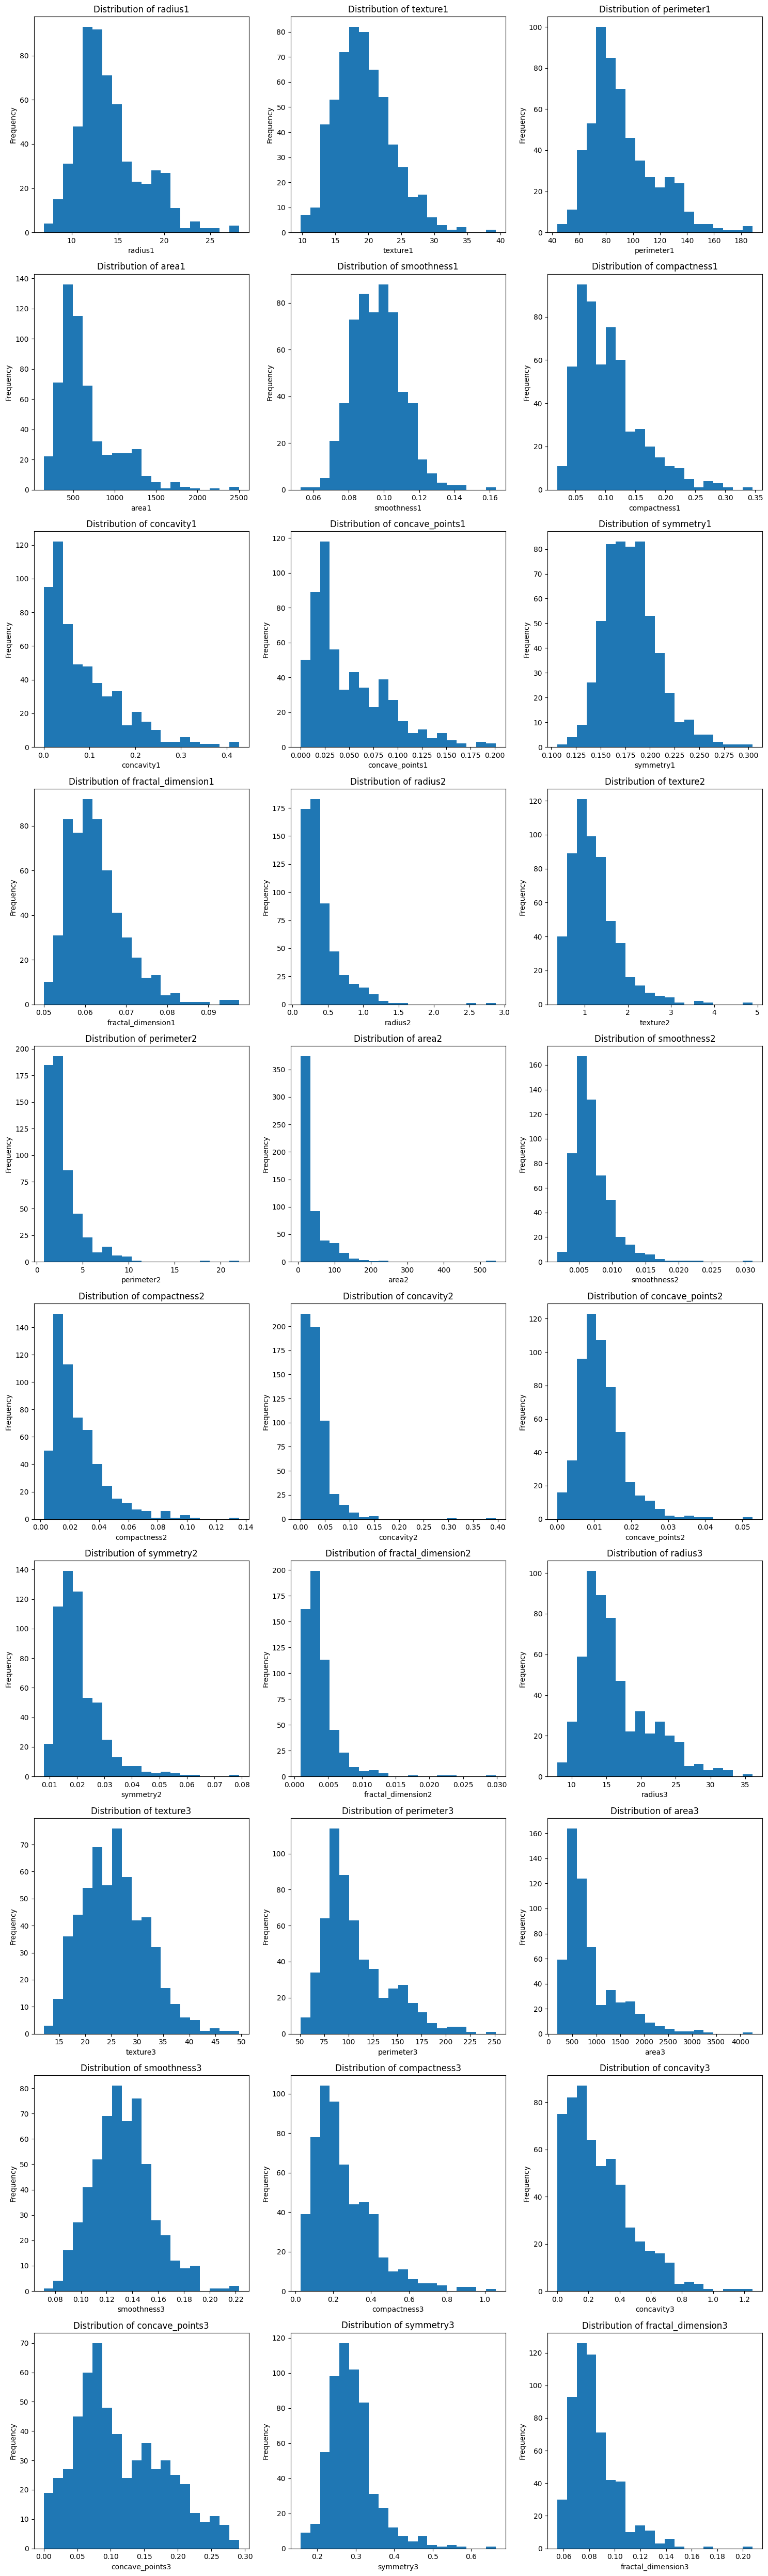

In [ ]:
# Plot histograms for each feature in X
num_features = len(X.columns)
rows = (num_features + 2) // 3  # Calculate the number of rows needed
plt.figure(figsize=(15, 5 * rows))  # Adjust figure size based on the number of rows


for i, col in enumerate(X.columns):
    plt.subplot(rows, 3, i + 1)
    plt.hist(X[col], bins=20)  # Adjust number of bins as needed
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Looks like we have a lot of correlated measures. We'll use PCA to reduce dimensionality of the dataset, while maintaining explained variance. We'll first scale our data.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Once we have scaled data, we'll examine the explained variance accross for PCA at different values of n.

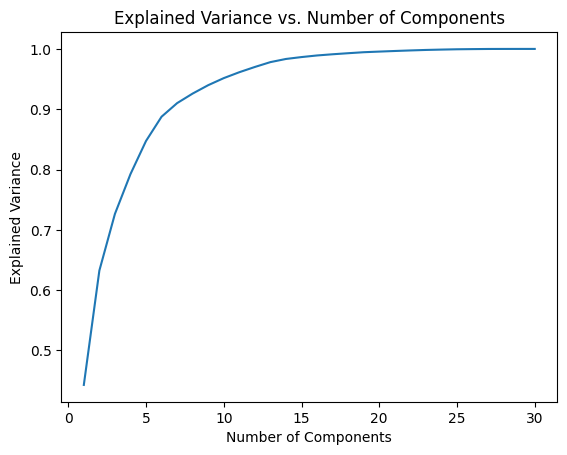

In [ ]:
results = []
for n in range(1, X.shape[1] + 1):  # Iterate through all possible components
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_.sum()
    results.append([n, explained_variance])

results_df = pd.DataFrame(results, columns=['n_components', 'explained_variance'])

plt.plot(results_df['n_components'], results_df['explained_variance'])
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()


It looks like we have a good explained variance at n=15, so we'll use that to reduce our dimensions for our modeling.

In [ ]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

## Model


We'll start with a helper function to help us with our diagnoses.

In [ ]:

import itertools

def label_permute_compare(ytdf,yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
# your code here
    true_labels = ytdf.values.flatten()
    unique_true = np.unique(true_labels)
    unique_pred = np.unique(yp)
    best_perm = None
    best_acc = 0

    # all possible permutations
    for perm in itertools.permutations(unique_true):
        label_mapping = {pred: true for pred, true in zip(unique_pred, perm)}
        mapped_labels = np.vectorize(lambda x: label_mapping[x])(yp)
        acc = np.mean(mapped_labels == true_labels)

        if acc > best_acc:
            best_acc = acc
            best_perm = perm

    return best_perm, best_acc


Hierarchical clustering:

Since we know we have two categories in 'Diagnosis', benign and malignant, we'll assign n_clusters = 2.

    Linkage     Metric  Accuracy
0      ward  euclidean  0.778559
1  complete  euclidean  0.662566
2  complete  manhattan  0.637961
3  complete     cosine  0.906854
4   average  euclidean  0.662566
5   average  manhattan  0.648506
6   average     cosine  0.906854
7    single  euclidean  0.629174
8    single  manhattan  0.629174
9    single     cosine  0.629174
Best Performance:  
Params -  ('complete', 'cosine') 
Accuracy -  0.9068541300527241


Text(0.5, 1.0, "Confusion Matrix - ('complete', 'cosine')")

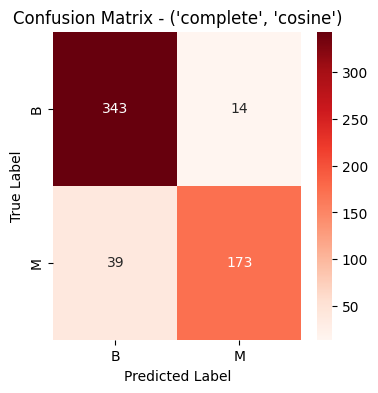

In [ ]:
#https://scikit-learn.org/0.15/modules/generated/sklearn.cluster.AgglomerativeClustering.html

linkage_methods = ["ward", "complete", "average", "single"]
distance_metrics = ["euclidean", "manhattan", "cosine"]

best_acc = 0
best_params = None
best_cluster_labels = []
best_labelorder = []
results = []

for linkage in linkage_methods:
    for metric in distance_metrics:
        # 'ward' linkage only supports 'euclidean' distance
        if linkage == "ward" and metric != "euclidean":
            continue

        # Fit AgglomerativeClustering model
        model = AgglomerativeClustering(n_clusters=2, linkage=linkage, metric=metric)
        cluster_labels = model.fit_predict(X_pca)

        labelorder, acc = label_permute_compare(y, cluster_labels)

        results.append((linkage, metric, acc))

        # Update best model if accuracy improves
        if acc > best_acc:
            best_acc = acc
            best_params = (linkage, metric)
            best_cluster_labels = cluster_labels
            best_labelorder = labelorder

#results in table form
df_results = pd.DataFrame(results, columns=["Linkage", "Metric", "Accuracy"])
print(df_results)
print("========================================")
#best params
print("Best Performance: ", "\nParams - ", best_params, "\nAccuracy - ", best_acc)
print("========================================")


#confusion matrix of best model
true_labels = []
for lab_val in y.values:
    true_labels.append(best_labelorder.index(lab_val))

#print(true_labels)

cm = confusion_matrix(true_labels, best_cluster_labels) #cluster = predicted

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=best_labelorder, yticklabels=best_labelorder)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - " + str(best_params))

The heirarchical apprach does a fairly good job of predicting whether whether a breast tumor is malignant or benign. Given the context of cancer diagnosis, this is especially concerning, as we're misclassifying malignant tumors as benign. We'll examine other approachs starting with k-means clustering.

In [ ]:
num_clusters = 2

# Apply K-Means clustering
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_cluster_labels = kmeans_model.fit_predict(X_pca)

kmeans_labelorder, kmeans_acc = label_permute_compare(y, kmeans_cluster_labels)
print(kmeans_labelorder)
print(kmeans_acc)

# use best parameters from previous cell
best_linkage, best_metric = best_params
hierarchical_model = AgglomerativeClustering(n_clusters=num_clusters, linkage=best_linkage, metric=best_metric)
hierarchical_cluster_labels = hierarchical_model.fit_predict(X_pca)

# Evaluate hierarchical clustering accuracy
hierarchical_labelorder, hierarchical_acc = label_permute_compare(y, hierarchical_cluster_labels)

# Compare results for time and accuracy
results = pd.DataFrame({
    "Clustering Method": ["K-Means", "Hierarchical"],
    "Accuracy": [kmeans_acc, hierarchical_acc]
})

results

('M', 'B')
0.8541300527240774


,Clustering Method,Accuracy
0,K-Means,0.854130
1,Hierarchical,0.906854


K-means does okay, but not quite as well as heirarchical clustering here. We'll see how NMF does

In [ ]:
def predict(w_matrix):
    sorted_w_mat = np.argsort(w_matrix)
    n_predictions, maxValue = sorted_w_mat.shape
    predictions = [[sorted_w_mat[i][maxValue - 1]] for i in range(n_predictions)]
    categories = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        categories[i] = predictions[i][0]
    return categories

In [ ]:
#shift to remove negatives for NMF
min_val = np.min(X_pca)
diff = abs(min_val)
X_pca_nmf = X_pca + diff


('M', 'B')
0.8927943760984183


Text(0.5, 1.0, 'Confusion Matrix - NMF')

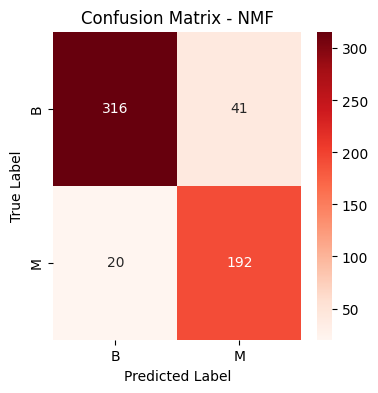

In [ ]:
nmf_model = NMF(n_components=2,
                init='nndsvda',
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 42)

nmf_model.fit(X_pca_nmf)
nmf_w = nmf_model.transform(X_pca_nmf)
nmf_h = nmf_model.components_
nmf_predictions = predict(nmf_w)

labelorder, nmf_acc = label_permute_compare(y, nmf_predictions)

print(labelorder)
print(nmf_acc)

true_labels = []
for lab_val in y.values:
    true_labels.append(best_labelorder.index(lab_val))

cm = confusion_matrix(true_labels, nmf_predictions) #cluster = predicted

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labelorder, yticklabels=labelorder)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - NMF")


In [ ]:
data = {'Clustering Method': ['Hierarchical', 'K-Means', 'NMF'],
        'Accuracy': [best_acc, kmeans_acc, nmf_acc]}
df = pd.DataFrame(data)
df


,Clustering Method,Accuracy
0,Hierarchical,0.906854
1,K-Means,0.854130
2,NMF,0.892794


Looks like Hieracrhical clustering performed best, but still not satisfactory if the intention is to use it for diagnoses. We'll see how a supervised approach works.

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9385964912280702
Precision: 0.938457254246728
Recall: 0.9385964912280702


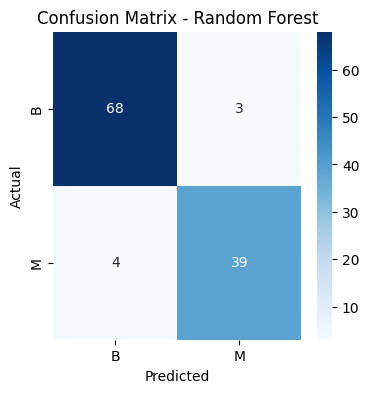

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Other metrics
precision = precision_score(y_test, y_pred, average='weighted') # Use weighted for multiclass
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:
# Create a DataFrame for the accuracy measures
data = {'Approach': ['Unsupervised', 'Unsupervised', 'Unsupervised', 'Supervised'],
        'Clustering Method': ['Hierarchical', 'K-Means', 'NMF', 'Random Forest'],
        'Accuracy': [best_acc, kmeans_acc, nmf_acc, accuracy]}
df_accuracy = pd.DataFrame(data)
df_accuracy


,Approach,Clustering Method,Accuracy
0,Unsupervised,Hierarchical,0.906854
1,Unsupervised,K-Means,0.854130
2,Unsupervised,NMF,0.892794
3,Supervised,Random Forest,0.938596


As expected the supervised approach did better here, as we are able to rely on the labeled output data to train our model.

## Conclusion

While we were relatively successful in predicting whether a breast tumor is malignant or benign, we were nowhere near the level of accuracy required for this kind of diagnosis, even with the supervised approach. As expected, a supervised machine learning approach is better suited for this kind of prediction. The next iteration of this project would be to examine hybrid approaches that use both methods, or other clustering methods.

## References


*   https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
*   Week 2 Lab

